# 5. Sparsify  solution paths (optional)

You can optionally sparsify (or *simplify*) solution paths up to the original maximum speeds of agents.

For example, suppose that you want to solve a problem instance with the max_speed of agents originally 0.2.
But let's first create a problem instance and timed roadmaps by specifying smaller max_speed, e.g., 0.05.

2022-12-13 09:50:37.199995: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-13 09:50:37.584769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-13 09:50:37.584841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-13 09:50:37.584848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


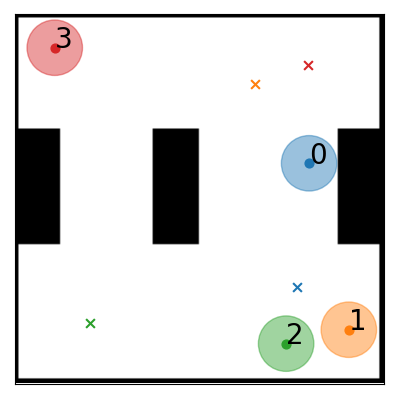

In [1]:
from jaxmapp.env.instance import InstanceGeneratorImageCollectionInput
from jaxmapp.roadmap import RandomSampler
from jaxmapp.utils import viz
import jax
import matplotlib.pyplot as plt

generator = InstanceGeneratorImageCollectionInput(num_agents_min=4, num_agents_max=4, max_speeds_cands=[0.05], rads_cands=[0.075],
                                                  imagedir="../data_example/map_data/")

ins = generator.generate(jax.random.PRNGKey(4))
viz.simple_plot_2d(ins)

# Random sampling
random_sampler = RandomSampler(share_roadmap=True, num_samples=1000, max_T=64)
trms_random = random_sampler.construct_trms(jax.random.PRNGKey(0), ins)

Then, solve the problem with `sparsify_time_steps=4`.

res_original=Status: solved, makespan: 22.00, sum-of-costs: 62.00, sum-of-costs (normed): 15.50
res_4=Status: solved, makespan: 6.00, sum-of-costs: 18.00, sum-of-costs (normed): 4.50


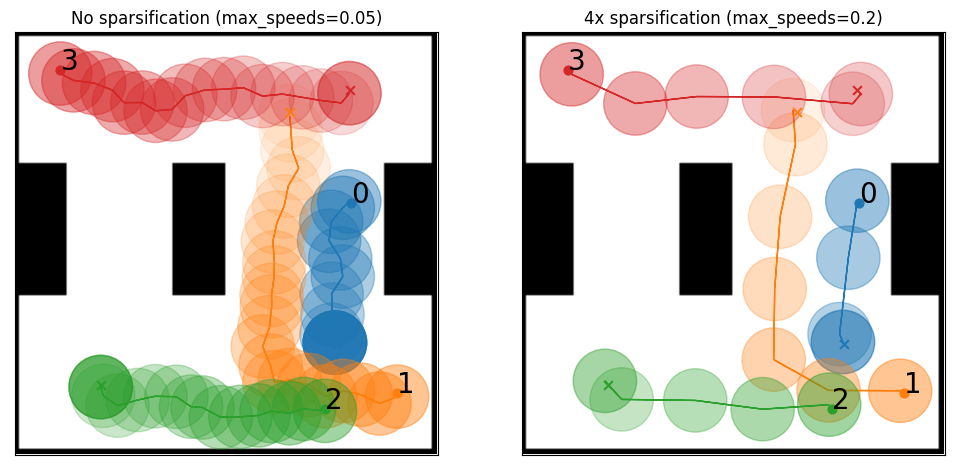

In [2]:
from jaxmapp.planner import PrioritizedPlanning

pp = PrioritizedPlanning(verbose=0)
res_original = pp.solve(ins.to_numpy(), trms_random, sparsify_time_steps=None)

print(f"{res_original=}")
res_4 = pp.solve(ins.to_numpy(), trms_random, sparsify_time_steps=4)
print(f"{res_4=}")


fig, axes = plt.subplots(1, 2, figsize=[12, 6])
viz.simple_plot_2d(ins, res_original, ax=axes[0])
axes[0].set_title("No sparsification (max_speeds=0.05)");
viz.simple_plot_2d(ins, res_4, ax=axes[1])
axes[1].set_title("4x sparsification (max_speeds=0.2)");

This will provide a solution first with `max_speed=0.05`, and then try to make it 4x sparser by subsampling the solution paths.
The sparsified solution paths are validated with `max_speed * time_steps = 0.05 * 4 = 0.2`, satisfying the original max_speed condition.

Note that sparsification will fail if the sparsified paths do not pass the `self.validate`. In such cases, the original unsparsified solution will be returned.

In [3]:
res_16 = pp.solve(ins.to_numpy(), trms_random, sparsify_time_steps=16)

ERROR:jaxmapp.planner.planner:conflict
ERROR:jaxmapp.planner.planner:Sparsification failed
